In [1]:
# NeuroMatch NeuroAI Project: 

'''
Simple Poject: RNN in a Grid World with t-SNE Visualization / Exploring a 2D gridworld and remembering previous locations
Description:

The agent explores a 2D gridworld by making random moves (up, down, left, right). At random timepoints, the agent is queried: 
“Where were you N steps ago?” -> we test different memory latencies -> plot output accuracy vs. latency to look at the “forgetting curve”.
Input: previous position, action taken (e.g., as one-hot vectors); the model must infer its new updated position.
After each move, update the hidden state of the model.
Output: With a certain probability (e.g. 10%), we ask “Where were you N steps ago?” (instead of “Where are you now” as in the demo) 
-> the network must output the position at t-N as classification problem 
-> Cross-entropy loss -> backprop the error.

'''
# Libraries:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import trange
import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.animation import PillowWriter
import matplotlib.patches as patches
from matplotlib import animation

In [2]:
# Model:
class MemoryRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        out, h = self.rnn(x.unsqueeze(1), h)
        return self.fc(out.squeeze(1)), h

# Utilities:
def pos_to_onehot(pos, grid_size):
    onehot = np.zeros(grid_size * grid_size)
    onehot[pos[0] * grid_size + pos[1]] = 1
    return onehot

def action_to_onehot(action):
    onehot = np.zeros(4)
    onehot[action] = 1
    return onehot

def move(pos, action, grid_size):
    x, y = pos
    if action == 0 and x > 0: x -= 1
    elif action == 1 and x < grid_size-1: x += 1
    elif action == 2 and y > 0: y -= 1
    elif action == 3 and y < grid_size-1: y += 1
    return (x, y)

In [3]:
# Training:
def train_model(N, grid_size=5, hidden_size=64, episodes=500, max_steps=100, query_prob=0.1):
    input_size = grid_size * grid_size + 4
    output_size = grid_size * grid_size
    model = MemoryRNN(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    criterion = nn.CrossEntropyLoss()

    for ep in trange(episodes, desc=f"Training N={N}"):
        pos = (np.random.randint(grid_size), np.random.randint(grid_size))
        history = deque(maxlen=N+1)
        h = torch.zeros(1, 1, hidden_size)

        for step in range(max_steps):
            action = np.random.choice(4)
            next_pos = move(pos, action, grid_size)
            input_vec = np.concatenate([pos_to_onehot(pos, grid_size), action_to_onehot(action)])
            input_tensor = torch.FloatTensor(input_vec).unsqueeze(0)
            logits, h = model(input_tensor, h.detach())

            history.append(pos)
            pos = next_pos

            if len(history) > N and random.random() < query_prob:
                target = history[0]
                target_idx = target[0] * grid_size + target[1]
                target_tensor = torch.LongTensor([target_idx])
                loss = criterion(logits, target_tensor)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    return model

In [4]:
# Testing:
def evaluate_model(model, N, grid_size=5, episodes=100, max_steps=100, query_prob=0.1):
    correct, total = 0, 0
    model.eval()

    with torch.no_grad():
        for _ in trange(episodes, desc=f"Testing N={N}"):
            pos = (np.random.randint(grid_size), np.random.randint(grid_size))
            history = deque(maxlen=N+1)
            h = torch.zeros(1, 1, model.rnn.hidden_size)

            for _ in range(max_steps):
                action = np.random.choice(4)
                next_pos = move(pos, action, grid_size)
                input_vec = np.concatenate([pos_to_onehot(pos, grid_size), action_to_onehot(action)])
                input_tensor = torch.FloatTensor(input_vec).unsqueeze(0)
                logits, h = model(input_tensor, h)

                history.append(pos)
                pos = next_pos

                if len(history) > N and random.random() < query_prob:
                    target = history[0]
                    target_idx = target[0] * grid_size + target[1]
                    pred_idx = torch.argmax(logits).item()
                    correct += (pred_idx == target_idx)
                    total += 1
    return correct / total if total > 0 else 0

# Full experiment:
def run_generalization_forgetting_curve(max_n=8):
    acc = []
    for N in range(1, max_n+1):
        model = train_model(N)
        accuracy = evaluate_model(model, N)
        acc.append(accuracy)
    return acc

Testing N=8: 100%|██████████| 100/100 [00:02<00:00, 45.33it/s]


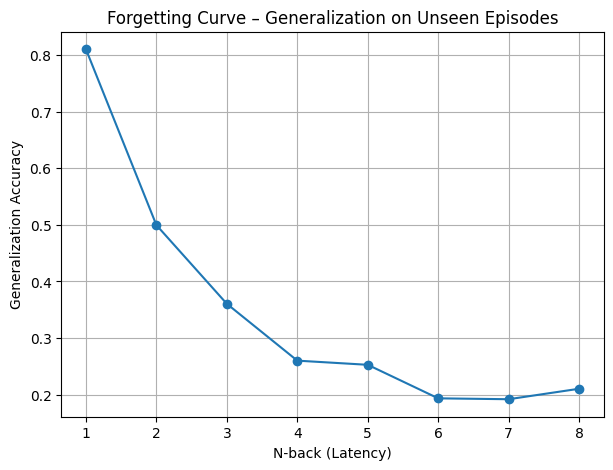

In [5]:
# Run:
forgetting_curve = run_generalization_forgetting_curve()

plt.figure(figsize=(7, 5))
plt.plot(range(1, len(forgetting_curve)+1), forgetting_curve, marker='o')
plt.xlabel("N-back (Latency)")
plt.ylabel("Generalization Accuracy")
plt.title("Forgetting Curve – Generalization on Unseen Episodes")
plt.grid(True)
plt.show()

In [ ]:
# Prepare environment and model for training:
grid_size = 5
N = 3
input_size = grid_size * grid_size + 4
output_size = grid_size * grid_size
hidden_size = 64
model = MemoryRNN(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

# Train the model:
for ep in range(100):
    pos = (np.random.randint(grid_size), np.random.randint(grid_size))
    history = deque(maxlen=N+1)
    h = torch.zeros(1, 1, hidden_size)
    for step in range(50):
        action = np.random.choice(4)
        next_pos = move(pos, action, grid_size)
        input_vec = np.concatenate([pos_to_onehot(pos, grid_size), action_to_onehot(action)])
        input_tensor = torch.FloatTensor(input_vec).unsqueeze(0)
        logits, h = model(input_tensor, h.detach())
        history.append(pos)
        pos = next_pos
        if len(history) > N and np.random.rand() < 0.2:
            target = history[0]
            target_idx = target[0] * grid_size + target[1]
            target_tensor = torch.LongTensor([target_idx])
            loss = criterion(logits, target_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [7]:
# Evaluate and collect hidden states:
confusion = np.zeros((grid_size * grid_size, grid_size * grid_size))
hidden_states = []
labels = []
model.eval()
with torch.no_grad():
    for _ in range(100):
        pos = (np.random.randint(grid_size), np.random.randint(grid_size))
        history = deque(maxlen=N+1)
        h = torch.zeros(1, 1, model.rnn.hidden_size)
        for _ in range(50):
            action = np.random.choice(4)
            next_pos = move(pos, action, grid_size)
            input_vec = np.concatenate([pos_to_onehot(pos, grid_size), action_to_onehot(action)])
            input_tensor = torch.FloatTensor(input_vec).unsqueeze(0)
            logits, h = model(input_tensor, h)
            history.append(pos)
            pos = next_pos
            if len(history) > N and np.random.rand() < 0.2:
                target = history[0]
                target_idx = target[0] * grid_size + target[1]
                pred_idx = torch.argmax(logits).item()
                confusion[target_idx, pred_idx] += 1
                hidden_states.append(h.squeeze(0).squeeze(0).numpy())
                labels.append(target_idx)

# Store for next cell (plotting):
confusion_matrix = confusion
tsne_inputs = np.array(hidden_states)
tsne_labels = np.array(labels)

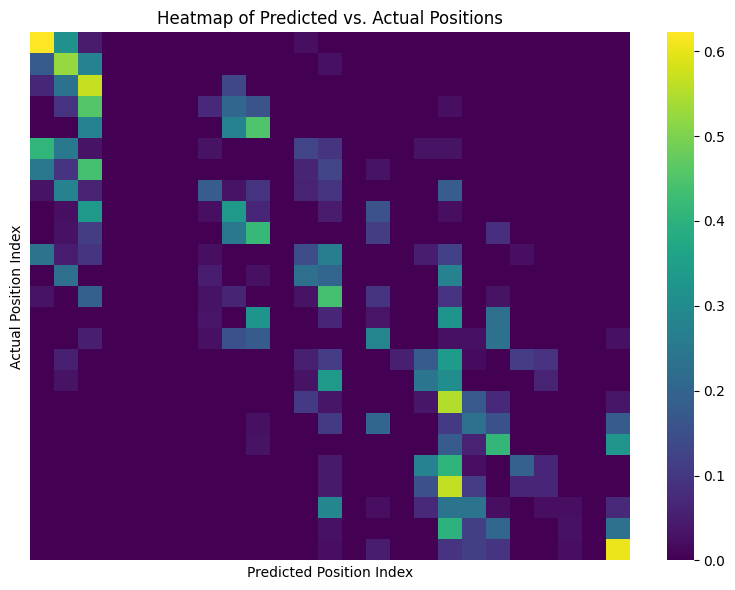

C:\Users\arthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


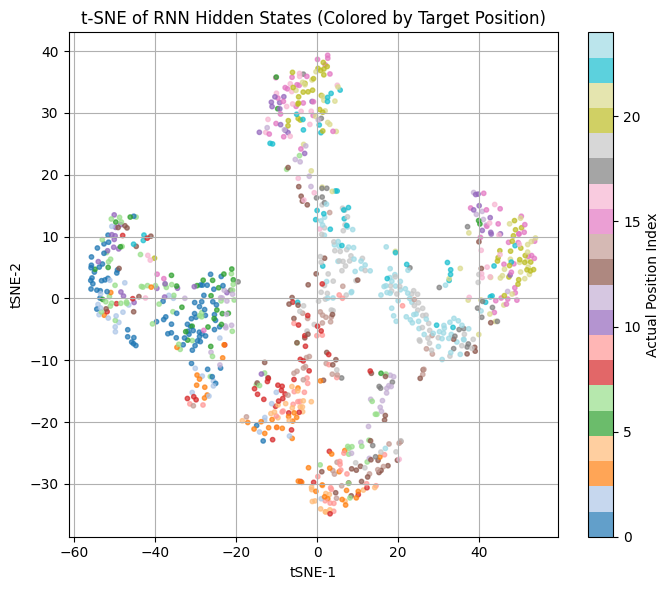

In [ ]:
# Normalize confusion matrix by row (true labels):
normalized_confusion = confusion_matrix / (confusion_matrix.sum(axis=1, keepdims=True) + 1e-9)
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_confusion, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("Heatmap of Predicted vs. Actual Positions")
plt.xlabel("Predicted Position Index")
plt.ylabel("Actual Position Index")
plt.tight_layout()
plt.show()

# T-SNE embedding of hidden states colored by actual target positions:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(tsne_inputs)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=tsne_labels, cmap='tab20', s=10, alpha=0.7)
plt.colorbar(scatter, label="Actual Position Index")
plt.title("t-SNE of RNN Hidden States (Colored by Target Position)")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.grid(True)
plt.tight_layout()
plt.show()

'C:\\Arthur\\OneDrive\\Documentos\\GitHub\\NeuroMatch_NeuroAI\\Project\\trajectory_vs_prediction.gif'

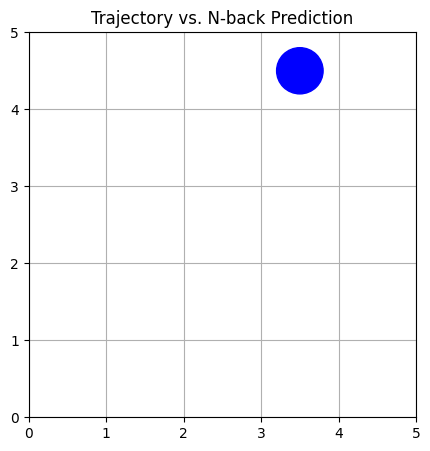

In [9]:
# Initialize model:
model = MemoryRNN(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

# Train briefly:
for ep in range(100):
    pos = (np.random.randint(grid_size), np.random.randint(grid_size))
    history = deque(maxlen=N+1)
    h = torch.zeros(1, 1, hidden_size)
    for step in range(50):
        action = np.random.choice(4)
        next_pos = move(pos, action, grid_size)
        input_vec = np.concatenate([pos_to_onehot(pos, grid_size), action_to_onehot(action)])
        input_tensor = torch.FloatTensor(input_vec).unsqueeze(0)
        logits, h = model(input_tensor, h.detach())
        history.append(pos)
        pos = next_pos
        if len(history) > N and np.random.rand() < 0.2:
            target = history[0]
            target_idx = target[0] * grid_size + target[1]
            target_tensor = torch.LongTensor([target_idx])
            loss = criterion(logits, target_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Generate trajectory:
trajectory, predictions, targets = [], [], []
pos = (np.random.randint(grid_size), np.random.randint(grid_size))
history = deque(maxlen=N+1)
h = torch.zeros(1, 1, model.rnn.hidden_size)
for _ in range(20):
    action = np.random.choice(4)
    next_pos = move(pos, action, grid_size)
    input_vec = np.concatenate([pos_to_onehot(pos, grid_size), action_to_onehot(action)])
    input_tensor = torch.FloatTensor(input_vec).unsqueeze(0)
    logits, h = model(input_tensor, h)
    history.append(pos)
    trajectory.append(pos)
    pos = next_pos
    if len(history) > N:
        target = history[0]
        pred_idx = torch.argmax(logits).item()
        pred_pos = (pred_idx // grid_size, pred_idx % grid_size)
        predictions.append(pred_pos)
        targets.append(target)
    else:
        predictions.append(None)
        targets.append(None)

# Animation:
fig, ax = plt.subplots(figsize=(5, 5))
def init():
    ax.clear()
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(range(grid_size + 1))
    ax.set_yticks(range(grid_size + 1))
    ax.grid(True)
    ax.set_title("Trajectory vs. N-back Prediction")

def animate(i):
    init()
    if i >= len(trajectory): return
    pos = trajectory[i]
    ax.add_patch(plt.Circle((pos[1]+0.5, grid_size-pos[0]-0.5), 0.3, color='blue'))
    if targets[i]:
        t = targets[i]
        ax.add_patch(plt.Circle((t[1]+0.5, grid_size-t[0]-0.5), 0.3, color='green', alpha=0.5))
    if predictions[i]:
        p = predictions[i]
        ax.add_patch(plt.Circle((p[1]+0.5, grid_size-p[0]-0.5), 0.3, color='red', alpha=0.5))

ani = animation.FuncAnimation(fig, animate, frames=len(trajectory), interval=800, repeat=False)
ani_path = r"C:\Arthur\OneDrive\Documentos\GitHub\NeuroMatch_NeuroAI\Project\trajectory_vs_prediction.gif"
ani.save(ani_path, writer=PillowWriter(fps=1))
ani_path